# Lab 05

## Import bibliotek

In [544]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from collections import deque
from PIL import Image

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Algorytm wyszukiwania wzorca 2-wymiarowego

In [545]:
# Use code from lab 01 to find patterns horizontally
def prefix_function(pattern):
    pi = [0]
    k = 0
    for q in range(1, len(pattern)):
        while k > 0 and pattern[k] != pattern[q]:
            k = pi[k-1]
        if pattern[k] == pattern[q]:
            k += 1
        pi.append(k)
    return pi

def kmp_string_matching(text, pattern, pi=None):
    if pi is None:
        pi = prefix_function(pattern)
        
    q = 0
    pattern_occurences = []
    for i in range(len(text)):
        while q > 0 and pattern[q] != text[i]:
            q = pi[q-1]
        if pattern[q] == text[i]:
            q += 1
        if q == len(pattern):
            pattern_occurences.append(i - q + 1)
            q = pi[q-1]
    return pattern_occurences

In [546]:
# Should use class here, but I'm lazy
TREE_SIZE = 0
NODES = []

class Node:
    def __init__(self, letter=None, parent=None, terminal=False) -> None:
        global TREE_SIZE, NODES
        self.letter = letter
        self.parent = self if parent is None else parent
        self.terminal = terminal
        self.id = TREE_SIZE
        TREE_SIZE += 1
        self.children = {}
        NODES.append(self)

    @staticmethod
    def get_by_id(id):
        return NODES[id] if id < len(NODES) else None


def build_tree(patterns):
    # Reset global variables
    global TREE_SIZE, NODES
    TREE_SIZE = 0
    NODES = []

    root = Node(letter=None, parent=None, terminal=False)
    for pattern in patterns:
        node = root
        for idx, letter in enumerate(pattern):
            terminal = idx == len(pattern) - 1

            if letter in node.children:
                node = node.children[letter]
                if terminal:
                    node.terminal = True
            else:
                new_node = Node(letter=letter, parent=node, terminal=terminal)
                node.children[letter] = new_node
                node = new_node

    return root

def print_tree(root):
    queue = deque()
    queue.append(root)
    while len(queue) > 0:
        node = queue.popleft()
        print(f'Node: {node.id}, Letter: {node.letter}, Terminal: {node.terminal}, Parent: {node.parent.id if node.parent else None}')
        for child in node.children.values():
            queue.append(child)

In [547]:
def build_multi_sma(root, patterns, alphabet):
    finals = []

    if root.terminal:
        finals.append(root.id)

    transition = [{} for _ in range(TREE_SIZE)]

    # Set edges for root
    for alphabet_letter in alphabet:
            transition[root.id][alphabet_letter] = 0

    queue = deque()
    queue.extend(root.children.values())

    while queue:
        node = queue.popleft()
        parent = node.parent
        letter = node.letter

        queue.extend(node.children.values())

        previous_state = transition[parent.id][letter]
        previous_node = Node.get_by_id(previous_state)
        transition[parent.id][letter] = node.id

        if node.terminal or previous_node.terminal:
            finals.append(node.id)

        for alphabet_letter in alphabet:
            if alphabet_letter in previous_node.children:
                transition[node.id][alphabet_letter] = previous_node.children[alphabet_letter].id
            else:
                transition[node.id][alphabet_letter] = transition[previous_state][alphabet_letter]

    return transition, finals

def build_state_matrix(multiline_text, transition, finals):
    state = 0
    max_line_length = max([len(line) for line in multiline_text])
    matrix = [[0 for _ in range(max_line_length)] for _ in range(len(multiline_text))]

    # Add padding to each line
    for line_idx in range(len(multiline_text)):
        line = multiline_text[line_idx]
        if type(line) == str:
            multiline_text[line_idx] = line + '$' * (max_line_length - len(line))
        else:   
            multiline_text[line_idx] = line + [0] * (max_line_length - len(line))

    # Scan each line vertically and save current state of the automaton in matrix
    for col_idx in range(max_line_length):
        state = 0
        for row_idx in range(len(multiline_text)):
            letter = multiline_text[row_idx][col_idx]
            state = transition[state][letter]
            matrix[row_idx][col_idx] = state

    return matrix

def find_pattern_occurences(text, patterns):
    # Build tree
    tree_patterns = []
    for i in range(len(patterns[0])):
        tree_patterns.append([pattern[i] for pattern in patterns])
        
    root = build_tree(tree_patterns)

    # Build the multi string matching automaton
    text_to_one_list = []
    for line in text:
        text_to_one_list.extend(line)

    pattern_to_one_list = []
    for pattern in patterns:
        pattern_to_one_list.extend(pattern)

    alphabet = set(text_to_one_list)
    alphabet.update(pattern_to_one_list)
    alphabet.add('$') 

    transition, finals = build_multi_sma(root, patterns, alphabet)

    # Build the state matrix for pattern and read horizontal sequance
    pattern_state_matrix = build_state_matrix(patterns, transition, finals)
    to_search = pattern_state_matrix[-1][:]

    # Search for pattern occurences in the text using fa_string_matching
    text_state_matrix = build_state_matrix(text, transition, finals)
    pattern_occurences = []
    for row_idx in range(len(text)):
        # found_patterns = fa_string_matching(text_state_matrix[row_idx], to_search)
        found_patterns = kmp_string_matching(text_state_matrix[row_idx], to_search)
        if found_patterns:
            pattern_occurences.extend([(row_idx, col_idx) for col_idx in found_patterns])

    return pattern_occurences

## Wszystkie sytuacje, gdy taka sama litera występuje na tej samej pozycji w dwóch kolejnych linijkach

In [548]:
with open('./haystack.txt') as file:
    haystack = file.readlines()
    # Remove \n from each line
    haystack = [line[:-1] for line in haystack]

In [549]:
for i in range(ord("a"), ord("z") + 1):
    found = find_pattern_occurences(haystack, [chr(i), chr(i)])
    print(f'Found {len(found)} occurences of {chr(i)}{chr(i)}')
    print(f'Occurences: {found}\n')

Found 28 occurences of aa
Occurences: [(1, 82), (4, 30), (6, 60), (7, 63), (21, 6), (29, 69), (32, 50), (32, 73), (34, 66), (38, 4), (53, 12), (54, 12), (54, 48), (57, 11), (58, 36), (59, 36), (60, 24), (65, 2), (65, 14), (65, 22), (66, 35), (70, 35), (77, 21), (77, 74), (78, 42), (78, 61), (79, 59), (80, 37)]

Found 0 occurences of bb
Occurences: []

Found 6 occurences of cc
Occurences: [(4, 54), (11, 45), (14, 10), (42, 0), (69, 0), (83, 41)]

Found 1 occurences of dd
Occurences: [(38, 19)]

Found 48 occurences of ee
Occurences: [(1, 63), (2, 8), (5, 77), (8, 65), (11, 1), (11, 64), (15, 2), (16, 43), (18, 6), (19, 27), (21, 10), (22, 61), (23, 53), (25, 3), (25, 65), (29, 67), (29, 73), (30, 38), (30, 43), (38, 48), (41, 11), (41, 26), (42, 57), (43, 36), (43, 48), (47, 52), (48, 50), (52, 31), (58, 54), (59, 50), (59, 54), (60, 73), (64, 66), (66, 69), (67, 72), (68, 17), (69, 46), (70, 15), (71, 49), (72, 38), (73, 23), (74, 27), (77, 6), (78, 6), (79, 65), (81, 6), (82, 14), (83,

## Wszystkie wystąpienia "th" oraz "t h" w dwóch kolejnych liniach na tej samej pozycji

In [550]:
found = find_pattern_occurences(haystack, ['th', 'th'])
print(f'Found {len(found)} occurences of thth')
print(f'Occurences: {found}\n')

Found 0 occurences of thth
Occurences: []



In [551]:
found = find_pattern_occurences(haystack, ['t h', 't h'])
print(f'Found {len(found)} occurences of thth')
print(f'Occurences: {found}\n')

Found 1 occurences of thth
Occurences: [(38, 0)]



## Znajdź wszystkie wystąpienia 4 małych liter (wybranych) w załączonym pliku "haystack.png"

In [552]:
def convert_image(file_name):
    image = Image.open(file_name)
    pixels = list(image.getdata())
    width, height = image.size
    text = []
    i = width
    for pixel in pixels:
        if i == width:
            i = 0
            text.append([])
        text[-1].append(pixel[0])
        i += 1
    return text

### Litera s

In [553]:
found = find_pattern_occurences(convert_image('./haystack.png'), convert_image('./patterns/s.png'))
print(f'Found {len(found)} occurences of letter s')

Found 334 occurences of letter s


In [554]:
found = find_pattern_occurences(convert_image('./haystack.png'), convert_image('./patterns/a.png'))
print(f'Found {len(found)} occurences of letter a')

Found 356 occurences of letter a


In [555]:
found = find_pattern_occurences(convert_image('./haystack.png'), convert_image('./patterns/l.png'))
print(f'Found {len(found)} occurences of letter l')

Found 169 occurences of letter l


In [556]:
found = find_pattern_occurences(convert_image('./haystack.png'), convert_image('./patterns/m.png'))
print(f'Found {len(found)} occurences of letter m')

Found 131 occurences of letter m


In [557]:
found = find_pattern_occurences(convert_image('./haystack.png'), convert_image('./patterns/pattern.png'))
print(f'Found {len(found)} occurences of pattern \'p a t t e r n\'')

Found 5 occurences of pattern 'p a t t e r n'


## Porównanie czasów budowania automatu i czasu wyszukiwania dla różnych rozmiarów wzorca

In [558]:
pattern_sizes = np.linspace(1, 10000, 100, dtype=int)
random_patterns = [["".join(np.random.choice(list('abcdefghijklmnopqrstuvwxyz'), size=size))] for size in pattern_sizes]

In [559]:
def measure_build_and_search_times(text, patterns):
    build_time = time.process_time()
    # Build tree
    tree_patterns = []
    for i in range(len(patterns[0])):
        tree_patterns.append([pattern[i] for pattern in patterns])
        
    root = build_tree(tree_patterns)

    # Build the multi string matching automaton
    text_to_one_list = []
    for line in text:
        text_to_one_list.extend(line)

    pattern_to_one_list = []
    for pattern in patterns:
        pattern_to_one_list.extend(pattern)

    alphabet = set(text_to_one_list)
    alphabet.update(pattern_to_one_list)
    alphabet.add('$') 

    transition, finals = build_multi_sma(root, patterns, alphabet)

    # Build the state matrix for pattern and read horizontal sequance
    pattern_state_matrix = build_state_matrix(patterns, transition, finals)
    to_search = pattern_state_matrix[-1][:]

    # Search for pattern occurences in the text using fa_string_matching
    text_state_matrix = build_state_matrix(text, transition, finals)

    build_time = time.process_time() - build_time   

    search_time = time.process_time()

    pattern_occurences = []
    for row_idx in range(len(text)):
        found_patterns = kmp_string_matching(text_state_matrix[row_idx], to_search)
        if found_patterns:
            pattern_occurences.extend([(row_idx, col_idx) for col_idx in found_patterns])

    search_time = time.process_time() - search_time

    return build_time, search_time


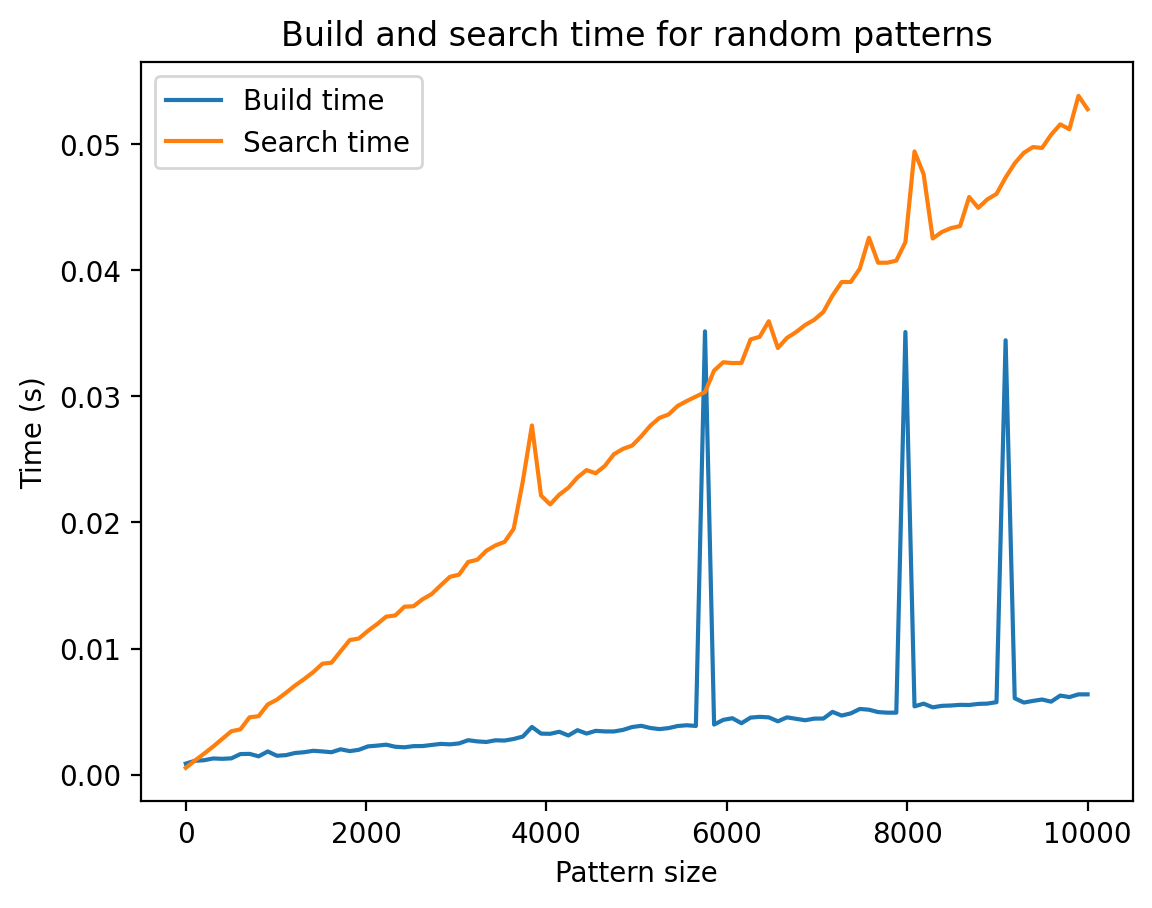

In [560]:
build_times = []
search_times = []

for pattern in random_patterns:
    build_time, search_time = measure_build_and_search_times(haystack, pattern)
    build_times.append(build_time)
    search_times.append(search_time)

plt.title('Build and search time for random patterns')
plt.plot(pattern_sizes, build_times, label='Build time')
plt.plot(pattern_sizes, search_times, label='Search time')
plt.xlabel('Pattern size')
plt.ylabel('Time (s)')
plt.legend()
plt.show()

## Podzielenie pliku na 2, 4 i 8 fragmentów (w poziomie) i porównanie czasu przeszukiwania

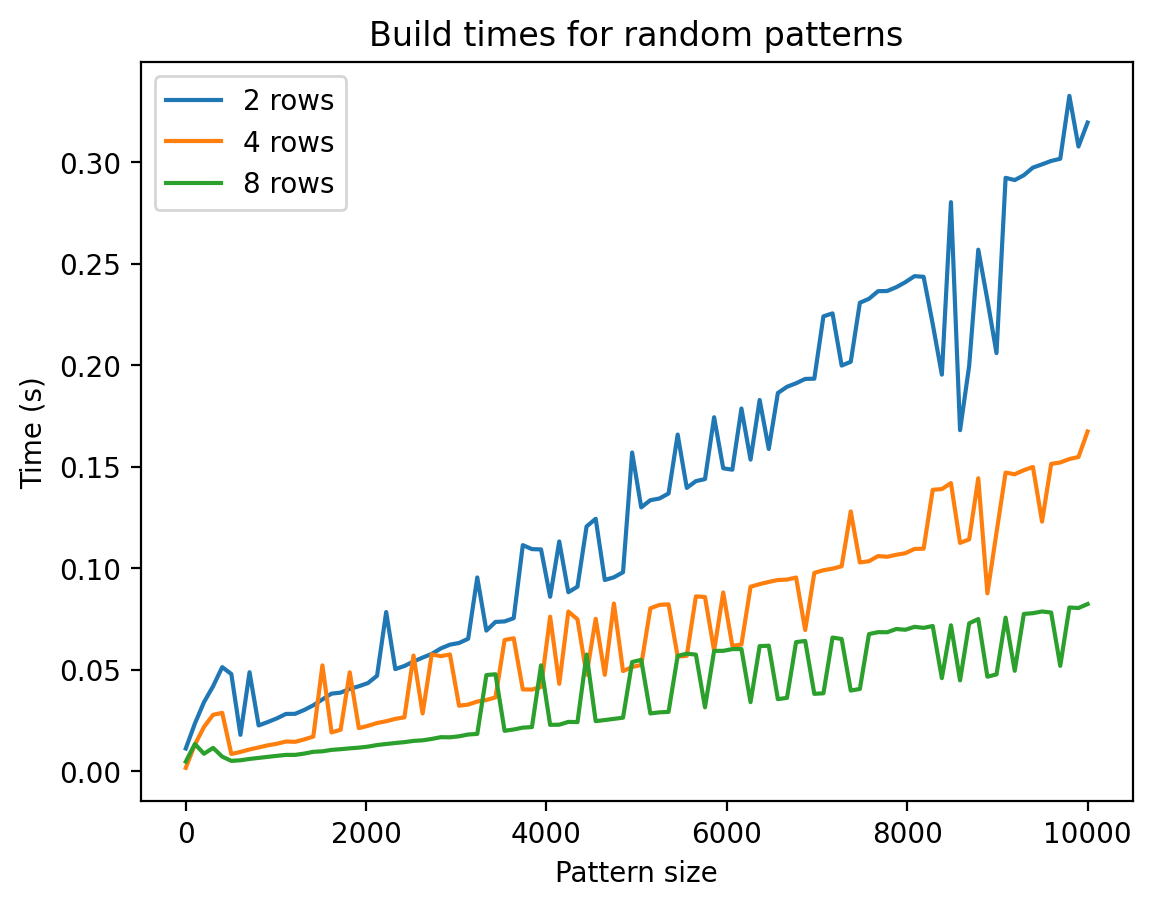

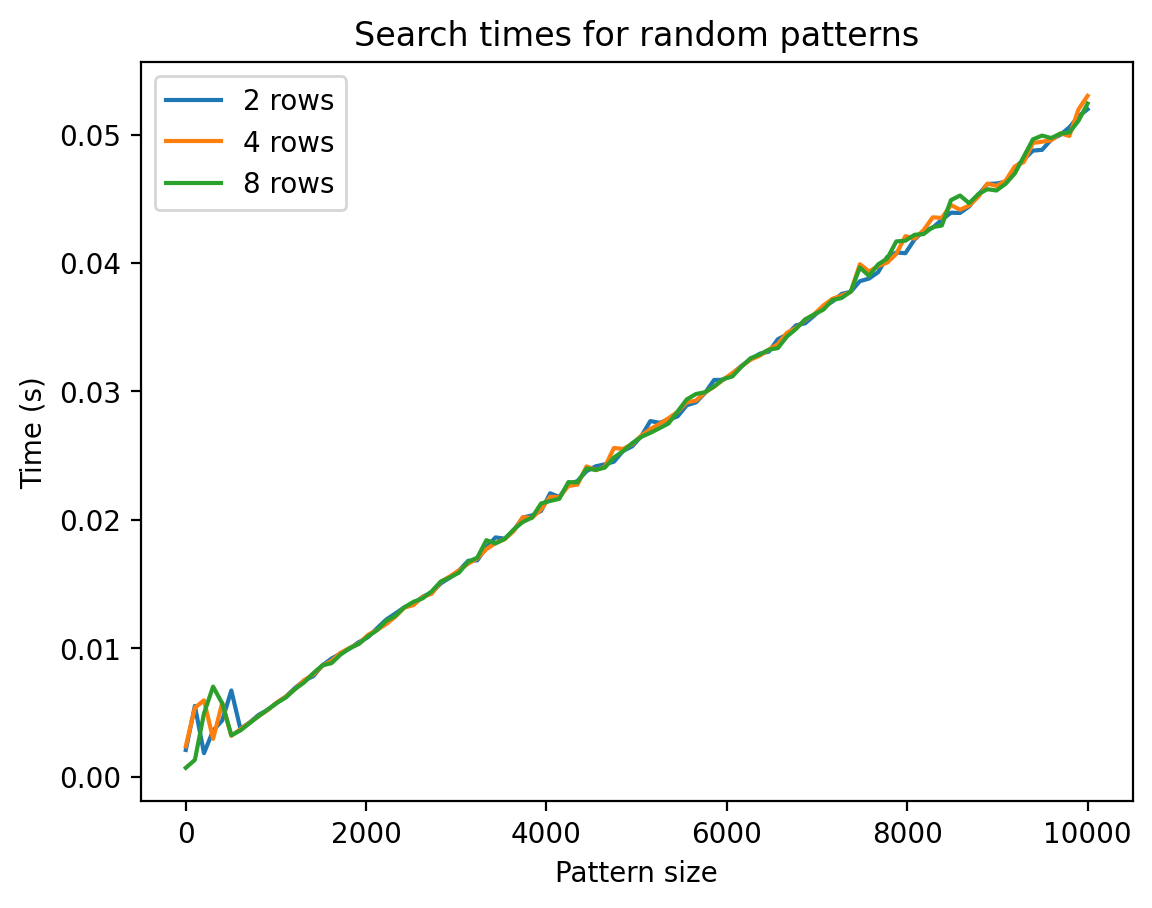

In [561]:
build_times_2_rows = []
search_times_2_rows = []
build_times_4_rows = []
search_times_4_rows = []
build_times_8_rows = []
search_times_8_rows = []

for pattern in random_patterns:
    for max_lines in [2,4,8]:
        if max_lines == 2:
            build_times = build_times_2_rows
            search_times = search_times_2_rows
        elif max_lines == 4:
            build_times = build_times_4_rows
            search_times = search_times_4_rows
        elif max_lines == 8:
            build_times = build_times_8_rows
            search_times = search_times_8_rows

        # Divide text into max_lines lines
        text = []
        i = max_lines
        for line in haystack:
            if i == max_lines:
                i = 0
                text.append([])
            text[-1].append(line)
            i += 1

        build_times.append(0)
        search_times.append(0)
        for x in text:
            build_time_i, search_time_i = measure_build_and_search_times(x, pattern)
            build_times[-1] += build_time_i
            search_times[-1] += search_time_i

plt.title('Build times for random patterns')
plt.plot(pattern_sizes, build_times_2_rows, label='2 rows')
plt.plot(pattern_sizes, build_times_4_rows, label='4 rows')
plt.plot(pattern_sizes, build_times_8_rows, label='8 rows')
plt.xlabel('Pattern size')
plt.ylabel('Time (s)')
plt.legend()
plt.show()

plt.title('Search times for random patterns')
plt.plot(pattern_sizes, search_times_2_rows, label='2 rows')
plt.plot(pattern_sizes, search_times_4_rows, label='4 rows')
plt.plot(pattern_sizes, search_times_8_rows, label='8 rows')
plt.xlabel('Pattern size')
plt.ylabel('Time (s)')
plt.legend()
plt.show()

## Wnioski

Uworzony automat prawidłowo wykrywa wzorce dwuwymiarowe. Przy porównaniu czasów budowy automatu i czasu wyszukiwania dla różnych rozmiarów wzorca można wywnioskować, że im większy (dłuższy) wzorzec, tym dłużej algorytm będzie działał. To zachowanie jest zgodne z oczekiwaniami. Podzielenie pliku na 2, 4 i 8 fragmentów (w poziomie) i porównanie czasu przeszukiwania pokazuje, że nie ma znaczenia, czy plik jest podzielony na 2, 4 czy 8 fragmentów. Czas przeszukiwania jest podobny dla każdego z tych przypadków. Natomiast sumaryczny czas budowy automatu jest krótszy dla mniejszej liczby fragmentów tekstu.